In [10]:
from flask import Flask
from flask_mysqldb import MySQL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans

In [11]:
mysql = MySQL()
app = Flask(__name__)

app.config['MYSQL_HOST'] = 'localhost'
app.config['MYSQL_USER'] = 'root'
app.config['MYSQL_PASSWORD'] = '@Obama123'
app.config['MYSQL_DB'] = 'sakila'

mysql = MySQL(app)

def closeConnect(conn):
    if conn != None:
        conn.close()

def queryDataset(sql):
    try:
        with app.app_context():
            cursor = mysql.connection.cursor()
            cursor.execute(sql)
            results = cursor.fetchall()
            df = pd.DataFrame(results)
            return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [38]:
if __name__ == '__main__':
    with app.app_context():
        sql = "SELECT c.customer_id, c.first_name, c.last_name, COUNT(DISTINCT r.rental_id) AS rental_count, SUM(p.amount) AS total_spent, f.film_id, f.title, COUNT(DISTINCT i.inventory_id) AS inventory_count " \
      "FROM customer c " \
      "JOIN rental r ON c.customer_id = r.customer_id " \
      "JOIN inventory i ON r.inventory_id = i.inventory_id " \
      "JOIN film f ON i.film_id = f.film_id " \
      "JOIN payment p ON r.rental_id = p.rental_id " \
      "GROUP BY c.customer_id, f.film_id, c.first_name, c.last_name, f.title " \
      "ORDER BY c.customer_id, rental_count DESC;"

        df = queryDataset(sql)
        df.columns = ['CustomerId', 'FirstName', 'LastName', 'RentalCount', 'TotalSpent', 'FilmId', 'Title', 'InventoryCount']
        if df is not None:
            print(df)
        else:
            print("Failed to fetch data.")

       CustomerId FirstName LastName  RentalCount TotalSpent  FilmId  \
0               1      MARY    SMITH            2       4.98     317   
1               1      MARY    SMITH            2       3.98     663   
2               1      MARY    SMITH            1       4.99       3   
3               1      MARY    SMITH            1       2.99      22   
4               1      MARY    SMITH            1       4.99      44   
...           ...       ...      ...          ...        ...     ...   
15823         599    AUSTIN  CINTRON            1       2.99     836   
15824         599    AUSTIN  CINTRON            1       2.99     869   
15825         599    AUSTIN  CINTRON            1       8.99     881   
15826         599    AUSTIN  CINTRON            1       1.99     891   
15827         599    AUSTIN  CINTRON            1       4.99    1000   

                       Title  InventoryCount  
0      FIREBALL PHILADELPHIA               2  
1             PATIENT SISTER             

In [39]:
df['TotalSpent'] = df['TotalSpent'].astype(float)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15828 entries, 0 to 15827
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerId      15828 non-null  int64  
 1   FirstName       15828 non-null  object 
 2   LastName        15828 non-null  object 
 3   RentalCount     15828 non-null  int64  
 4   TotalSpent      15828 non-null  float64
 5   FilmId          15828 non-null  int64  
 6   Title           15828 non-null  object 
 7   InventoryCount  15828 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 989.4+ KB


In [41]:
df.describe()

,CustomerId,RentalCount,TotalSpent,FilmId,InventoryCount
count,15828.000000,15828.000000,15828.000000,15828.000000,15828.000000
mean,297.246336,1.013647,4.258691,500.727003,1.013647
std,172.422141,0.118181,2.444558,288.382327,0.118181
min,1.000000,1.000000,0.000000,1.000000,1.000000
25%,148.000000,1.000000,2.990000,255.000000,1.000000
50%,296.000000,1.000000,3.990000,496.000000,1.000000
75%,446.000000,1.000000,5.990000,753.000000,1.000000
max,599.000000,3.000000,18.980000,1000.000000,3.000000


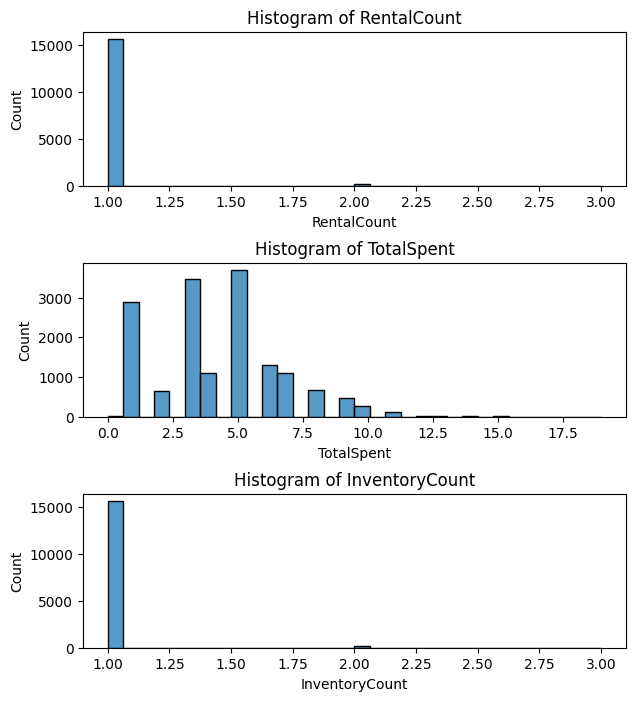

In [43]:
def showHistogram(df, columns):
    plt.figure(figsize=(7, 8))
    n = 0
    for column in columns:
        n += 1
        plt.subplot(len(columns), 1, n)  # Cập nhật số hàng dựa trên số lượng cột
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        sns.histplot(df[column], bins=32)
        plt.title(f'Histogram of {column}')
    plt.show()

columns = ['RentalCount', 'TotalSpent', 'InventoryCount']
showHistogram(df, columns)


c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

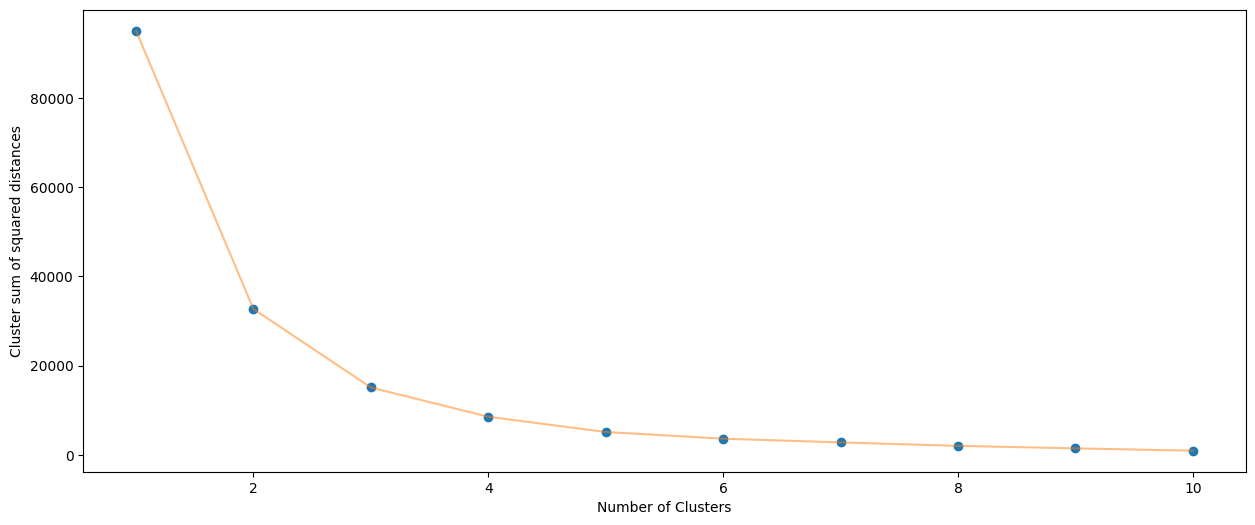

In [44]:
def elbowMethod(df, columnsForElbow):
    X = df.loc[:, columnsForElbow].values
    inertia = []

    for n in range(1, 11):
        model = KMeans(n_clusters=n, init='k-means++', max_iter=500, random_state=42)
        model.fit(X)
        inertia.append(model.inertia_)

    plt.figure(1, figsize=(15,6))
    plt.plot(np.arange(1, 11), inertia, 'o')
    plt.plot(np.arange(1, 11), inertia, '-', alpha=0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Cluster sum of squared distances')
    plt.show()

columns = ['RentalCount', 'TotalSpent', 'InventoryCount']
elbowMethod(df, columns)

=> 3 clusters

In [51]:
def runKMeans(X, n_clusters):
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, random_state=42)
    model.fit(X)
    labels = model.labels_
    centroids = model.cluster_centers_
    y_kmeans = model.fit_predict(X)
    return y_kmeans, centroids, labels

In [46]:
X = df.loc[:, columns].values
cluster = 4
colors = ['red', 'green', 'blue', 'purple', 'black', 'pink', 'orange']

In [52]:
y_kmeans, centroids, labels = runKMeans(X, cluster)

c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [53]:
y_kmeans

array([0, 2, 0, ..., 3, 1, 0])

In [54]:
centroids

array([[1.01015395, 5.56636751, 1.01015395],
       [1.0045007 , 1.16245288, 1.0045007 ],
       [1.00504054, 3.2296888 , 1.00504054],
       [1.07169576, 9.07028055, 1.07169576]])

In [55]:
labels

array([0, 2, 0, ..., 3, 1, 0])

In [56]:
df['cluster'] = labels

In [68]:
import plotly.express as px

def visualize3DKmeans(df, columns, hover_data, n_clusters):
    # Ensure 'cluster' is a column in df used for color
    fig = px.scatter_3d(df, x=columns[0], y=columns[1], z=columns[2],
                        color='cluster', hover_data=hover_data,
                        category_orders={'cluster': range(0, n_clusters)})
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

In [70]:
!pip install nbformat>=4.2.0

hover_data = df.columns
visualize3DKmeans(df, columns, hover_data, cluster)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed